In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.wcs import WCS
import os
import time
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import pandas as pd
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
import healpy as hp
from copy import copy, deepcopy
import logging, traceback
import sys
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [2]:
# cd to code directory
#%cd /Users/tparsota/Documents/BAT_SCRIPTS/NITRATES/NITRATES_GIT/NITRATES 
#/storage/work/j/jjd330/local/bat_data/BatML

In [3]:
#from event2dpi_funcs import det2dpis, mask_detxy
#from flux_models import Cutoff_Plaw_Flux, Plaw_Flux, get_eflux_from_model
#from sqlite_funcs import get_conn
#from dbread_funcs import get_info_tab
#from do_manage2 import im_dist, get_rate_res_fnames, get_peak_res_fnames, get_out_res_fnames,\
#                    get_merged_csv_df, get_merged_csv_df_wpos
#from hp_funcs import ang_sep
#from coord_conv_funcs import theta_phi2imxy, imxy2theta_phi, convert_imxy2radec,\
#                            convert_radec2thetaphi, convert_radec2imxy
#from do_llh_inFoV4realtime2 import parse_bkg_csv
#from LLH import LLH_webins
#from minimizers import NLLH_ScipyMinimize_Wjacob


os.environ['NITRATES_RESP_DIR'] = '/Users/tparsota/Documents/BAT_SCRIPTS/NITRATES_BAT_RSP_FILES/'
import nitrates
from nitrates.config import rt_dir, solid_angle_dpi_fname
from nitrates.lib import get_conn, det2dpi, mask_detxy, get_info_tab, get_twinds_tab, ang_sep, theta_phi2imxy, \
    imxy2theta_phi, convert_imxy2radec, convert_radec2thetaphi, convert_radec2imxy
from nitrates.response import RayTraces
from nitrates.models import Cutoff_Plaw_Flux, Plaw_Flux, get_eflux_from_model
from nitrates.llh_analysis import parse_bkg_csv, LLH_webins, NLLH_ScipyMinimize_Wjacob, get_out_res_fnames
from nitrates.llh_analysis import im_dist, get_rate_res_fnames, get_peak_res_fnames, \
    get_merged_csv_df, get_merged_csv_df_wpos
print(nitrates.config.NITRATES_RESP_DIR)


sh: https://heasarc.gsfc.nasa.gov/FTP/caldb/caldbinit.sh: No such file or directory


No module named 'ROOT'
Please install the Python ROOT package to be able to run the full forward modeling calculations.
16
16
[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]), array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]), array([37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]), array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68]), array([73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]), array([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104]), array([109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122]), array([127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140]), array([145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158]), array([163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175,
       176]), array([181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194]), array([199, 200, 201, 202, 203, 

In [4]:
ebins0 = np.array([15.0, 24.0, 35.0, 48.0, 64.0])
ebins0 = np.append(ebins0, np.logspace(np.log10(84.0), np.log10(500.0), 5+1))[:-1]
ebins0 = np.round(ebins0, decimals=1)[:-1]
ebins1 = np.append(ebins0[1:], [350.0])
nebins = len(ebins0)
print("Number of ebins: ", nebins)


# directory with results
#work_dir = '/Users/tparsota/Documents/BAT_SCRIPTS/NITRATES/F646018360/'
#'/storage/work/j/jjd330/local/bat_data/realtime_workdir/F646018360/'

NITRATES_path=nitrates.config.NITRATES_RESP_DIR
work_dir = os.path.join(NITRATES_path, 'F646018360')
conn = get_conn(os.path.join(work_dir,'results.db'))
info_tab = get_info_tab(conn)
# trigger time stored in results.db (sqlite DB)
# not much else stored there (results used to be stored there but not anymore)
trigger_time = info_tab['trigtimeMET'][0]
print("trigger time: ", trigger_time)

# default file names made by do_data_setup.py
evfname = os.path.join(work_dir,'filter_evdata.fits')
ev_data = fits.open(evfname)[1].data
# GTI extensions added to event fits file by do_data_setup.py
GTI_PNT = Table.read(evfname, hdu='GTI_POINTING') # when the analysis can be run (good data time and pointing)
GTI_SLEW = Table.read(evfname, hdu='GTI_SLEW') # slewing times
# the final set of detectors to mask (disabled dets, hot/cold dets, and dets with glitches)  
dmask = fits.open(os.path.join(work_dir,'detmask.fits'))[0].data
attfile = fits.open(os.path.join(work_dir,'attitude.fits'))[1].data

# number of detectors being used
ndets = np.sum(dmask==0)
print ("Ndets: ", np.sum(dmask==0))

t_end = trigger_time + 1e3
t_start = trigger_time - 1e3
mask_vals = mask_detxy(dmask, ev_data)
bl_dmask = (dmask==0.)

# get rid of events:
# far away from trigger time
# from bad dets
# with bad event flags
bl_ev = (ev_data['EVENT_FLAGS']<1)&\
        (ev_data['ENERGY']<=500.)&(ev_data['ENERGY']>=14.)&\
        (mask_vals==0.)&(ev_data['TIME']<=t_end)&\
        (ev_data['TIME']>=t_start)

print("Number of events passing cuts: ", np.sum(bl_ev))
ev_data0 = ev_data[bl_ev]


Number of ebins:  9
trigger time:  646018383.1787
Ndets:  14932
Number of events passing cuts:  1367885


In [5]:
print (GTI_PNT)
print()
for row in GTI_PNT:
    print (row['START'] - trigger_time, row['STOP'] - trigger_time)


   START         STOP     
     s            s       
----------- --------------
646018333.0 646018533.0953

-50.17869997024536 149.91659998893738


In [6]:
bkg_fname = os.path.join(work_dir,'bkg_estimation.csv')
bkg_df = pd.read_csv(bkg_fname)


In [7]:
bkg_df.head()


,4U 1700-377_imx,4U 1700-377_imy,4U 1700-377_rate_0,4U 1700-377_rate_1,4U 1700-377_rate_2,4U 1700-377_rate_3,4U 1700-377_rate_4,4U 1700-377_rate_5,4U 1700-377_rate_6,4U 1700-377_rate_7,4U 1700-377_rate_8,Background_bkg_rate_0,Background_bkg_rate_1,Background_bkg_rate_2,Background_bkg_rate_3,Background_bkg_rate_4,Background_bkg_rate_5,Background_bkg_rate_6,Background_bkg_rate_7,Background_bkg_rate_8,Background_flat_0,Background_flat_1,Background_flat_2,Background_flat_3,Background_flat_4,Background_flat_5,Background_flat_6,Background_flat_7,Background_flat_8,GRO J1655-40_imx,GRO J1655-40_imy,GRO J1655-40_rate_0,GRO J1655-40_rate_1,GRO J1655-40_rate_2,GRO J1655-40_rate_3,GRO J1655-40_rate_4,GRO J1655-40_rate_5,GRO J1655-40_rate_6,GRO J1655-40_rate_7,GRO J1655-40_rate_8,GX 339-4_imx,GX 339-4_imy,GX 339-4_rate_0,GX 339-4_rate_1,GX 339-4_rate_2,GX 339-4_rate_3,GX 339-4_rate_4,GX 339-4_rate_5,GX 339-4_rate_6,GX 339-4_rate_7,GX 339-4_rate_8,Sco X-1_imx,Sco X-1_imy,Sco X-1_rate_0,Sco X-1_rate_1,Sco X-1_rate_2,Sco X-1_rate_3,Sco X-1_rate_4,Sco X-1_rate_5,Sco X-1_rate_6,Sco X-1_rate_7,Sco X-1_rate_8,corr_4U 1700-377_rate_0_GRO J1655-40_rate_0,corr_4U 1700-377_rate_0_GX 339-4_rate_0,corr_4U 1700-377_rate_1_GRO J1655-40_rate_1,corr_4U 1700-377_rate_1_GX 339-4_rate_1,corr_4U 1700-377_rate_2_GRO J1655-40_rate_2,corr_4U 1700-377_rate_2_GX 339-4_rate_2,corr_4U 1700-377_rate_3_GRO J1655-40_rate_3,corr_4U 1700-377_rate_3_GX 339-4_rate_3,corr_4U 1700-377_rate_4_GRO J1655-40_rate_4,corr_4U 1700-377_rate_4_GX 339-4_rate_4,corr_4U 1700-377_rate_5_GRO J1655-40_rate_5,corr_4U 1700-377_rate_5_GX 339-4_rate_5,corr_4U 1700-377_rate_6_GRO J1655-40_rate_6,corr_4U 1700-377_rate_6_GX 339-4_rate_6,corr_4U 1700-377_rate_7_GRO J1655-40_rate_7,corr_4U 1700-377_rate_7_GX 339-4_rate_7,corr_4U 1700-377_rate_8_GRO J1655-40_rate_8,corr_4U 1700-377_rate_8_GX 339-4_rate_8,corr_Background_bkg_rate_0_4U 1700-377_rate_0,corr_Background_bkg_rate_0_GRO J1655-40_rate_0,corr_Background_bkg_rate_0_GX 339-4_rate_0,corr_Background_bkg_rate_0_Sco X-1_rate_0,corr_Background_bkg_rate_1_4U 1700-377_rate_1,corr_Background_bkg_rate_1_GRO J1655-40_rate_1,corr_Background_bkg_rate_1_GX 339-4_rate_1,corr_Background_bkg_rate_1_Sco X-1_rate_1,corr_Background_bkg_rate_2_4U 1700-377_rate_2,corr_Background_bkg_rate_2_GRO J1655-40_rate_2,corr_Background_bkg_rate_2_GX 339-4_rate_2,corr_Background_bkg_rate_2_Sco X-1_rate_2,corr_Background_bkg_rate_3_4U 1700-377_rate_3,corr_Background_bkg_rate_3_GRO J1655-40_rate_3,corr_Background_bkg_rate_3_GX 339-4_rate_3,corr_Background_bkg_rate_3_Sco X-1_rate_3,corr_Background_bkg_rate_4_4U 1700-377_rate_4,corr_Background_bkg_rate_4_GRO J1655-40_rate_4,corr_Background_bkg_rate_4_GX 339-4_rate_4,corr_Background_bkg_rate_4_Sco X-1_rate_4,corr_Background_bkg_rate_5_4U 1700-377_rate_5,corr_Background_bkg_rate_5_GRO J1655-40_rate_5,corr_Background_bkg_rate_5_GX 339-4_rate_5,corr_Background_bkg_rate_5_Sco X-1_rate_5,corr_Background_bkg_rate_6_4U 1700-377_rate_6,corr_Background_bkg_rate_6_GRO J1655-40_rate_6,corr_Background_bkg_rate_6_GX 339-4_rate_6,corr_Background_bkg_rate_6_Sco X-1_rate_6,corr_Background_bkg_rate_7_4U 1700-377_rate_7,corr_Background_bkg_rate_7_GRO J1655-40_rate_7,corr_Background_bkg_rate_7_GX 339-4_rate_7,corr_Background_bkg_rate_7_Sco X-1_rate_7,corr_Background_bkg_rate_8_4U 1700-377_rate_8,corr_Background_bkg_rate_8_GRO J1655-40_rate_8,corr_Background_bkg_rate_8_GX 339-4_rate_8,corr_Background_bkg_rate_8_Sco X-1_rate_8,corr_GRO J1655-40_rate_0_GX 339-4_rate_0,corr_GRO J1655-40_rate_1_GX 339-4_rate_1,corr_GRO J1655-40_rate_2_GX 339-4_rate_2,corr_GRO J1655-40_rate_3_GX 339-4_rate_3,corr_GRO J1655-40_rate_4_GX 339-4_rate_4,corr_GRO J1655-40_rate_5_GX 339-4_rate_5,corr_GRO J1655-40_rate_6_GX 339-4_rate_6,corr_GRO J1655-40_rate_7_GX 339-4_rate_7,corr_GRO J1655-40_rate_8_GX 339-4_rate_8,corr_Sco X-1_rate_0_4U 1700-377_rate_0,corr_Sco X-1_rate_0_GRO J1655-40_rate_0,corr_Sco X-1_rate_0_GX 339-4_rate_0,corr_Sco X-1_rate_1_4U 1700-377_rate_1,corr_Sco X-1

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-BoldOblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/a

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUniBol.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHanifiRohingya-Regular.ttf', name='Noto Sans Hanifi Rohingya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tamil MN.ttc', name='Tamil MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow Italic.ttf', name='Arial Narrow', style='italic', variant='normal', weight=400, stretch='condensed', size='scalable')) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Georgia Italic.ttf', name='Georgia', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fn

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansDuployan-Regular.ttf', name='Noto Sans Duployan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSerif.ttc', name='PT Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trebuchet MS Italic.ttf', name='Trebuchet MS', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/F

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Phosphate.ttc', name='Phosphate', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trattatello.ttf', name='Trattatello', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCuneiform-Regular.ttf', name='Noto Sans Cuneiform', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansVai-Regular.ttf', name='Noto Sans Vai', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syst

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72 Smallcaps Book.ttf', name='Bodoni 72 Smallcaps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansChakma-Regular.ttf', name='Noto Sans Chakma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNabataean-Regular.ttf', name='Noto Sans Nabataean', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXIntUpBol.otf', name='STIXIntegralsUp', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:f

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMono.ttf', name='.SF NS Mono', style='normal', variant='normal', weight=295, stretch='normal', size='scalable')) = 10.14975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kannada MN.ttc', name='Kannada MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizTwoSymReg.otf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansElbasan-Regular.ttf', name='Noto Sans Elbasan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTakri-Regular.ttf', name='Noto Sans Takri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansInscriptionalPahlavi-Regular.ttf', name='Noto Sans Inscriptional Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Mishafi.ttf', name='Mishafi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Narrow.ttf', name='Arial Narrow', style='normal', variant='normal', weight=400, stretch='condensed', size='scalable')) = 10.25
DEBUG:matplotlib.font_manager:findfont: 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ丸ゴ ProN W4.ttc', name='Hiragino Maru Gothic Pro', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansImperialAramaic-Regular.ttf', name='Noto Sans Imperial Aramaic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansOriya.ttc', name='Noto Sans Oriya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansKannada.ttc', name='Noto Sans Kannada', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Italic.ttf', name='Times New Roman', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Avenir.ttc', name='Avenir', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Khmer MN.ttc', 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Andale Mono.ttf', name='Andale Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansMyanmar.ttc', name='Noto Sans Myanmar', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ChalkboardSE.ttc', name='Chalkboard SE', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Iowan 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmtt10.ttf', name='cmtt10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/Deja

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf', name='Noto Sans Psalter Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings 2.ttf', name='Wingdings 2', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHanifiRohingya-Regular.ttf', name='Noto Sans Hanifi Rohingya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tamil MN.ttc', name='Tamil MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfo

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Hoefler Text.ttc', name='Hoefler Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman.ttf', name='Times New Roman', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Webdings.ttf', name='Webdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansDuployan-Regular.ttf', name='Noto Sans Duployan', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/L

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorGujarati.ttc', name='Kohinoor Gujarati', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkboard.ttc', name='Chalkboard', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Phosphate.ttc', name='Phosphate', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Trattatello.ttf', name='Trattatello', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoS

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactRounded.ttf', name='.SF Compact Rounded', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Lao MN.ttc', name='Lao MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72 Smallcaps Book.ttf', name='Bodoni 72 Smallcaps', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansChakma-Regular.ttf', name='Noto Sans Chakma', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Syste

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKharoshthi-Regular.ttf', name='Noto Sans Kharoshthi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorTelugu.ttc', name='Kohinoor Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFNSMono.ttf', name='.SF NS Mono', style='normal', variant='normal', weight=295, stretch='normal', size='scalable')) = 10.14975
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Kannada MN.ttc', name='Kannada MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Suppleme

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Al Nile.ttc', name='Al Nile', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Galvji.ttc', name='Galvji', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTakri-Regular.ttf', name='Noto Sans Takri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansInscriptionalPahlavi-Regular.ttf', name='Noto Sans Inscriptional Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Menlo.ttc', name='Menlo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi.ttf', name='Gurmukhi MT', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSylotiNagri-Regular.ttf', name='Noto Sans Syloti Nagri', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTaiTham-Regular.ttf', name='Noto Sans Tai Tham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Librar

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Symbol.ttf', name='Symbol', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansOriya.ttc', name='Noto Sans Oriya', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansKannada.ttc', name='Noto Sans Kannada', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Times New Roman Italic.tt

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu Sangam MN.ttc', name='Telugu Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Optima.ttc', name='Optima', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Andale Mono.ttf', name='Andale Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSans.ttc', name='PT Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/NotoSansMyanmar.ttc', name='Noto 

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTifinagh-Regular.ttf', name='Noto Sans Tifinagh', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansSoraSompeng-Regular.ttf', name='Noto Sans Sora Sompeng', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTagalog-Regular.ttf', name='Noto Sans Tagalog', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldItalic-Regular.ttf', name='Noto Sans Old Italic', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
DEBUG:ma

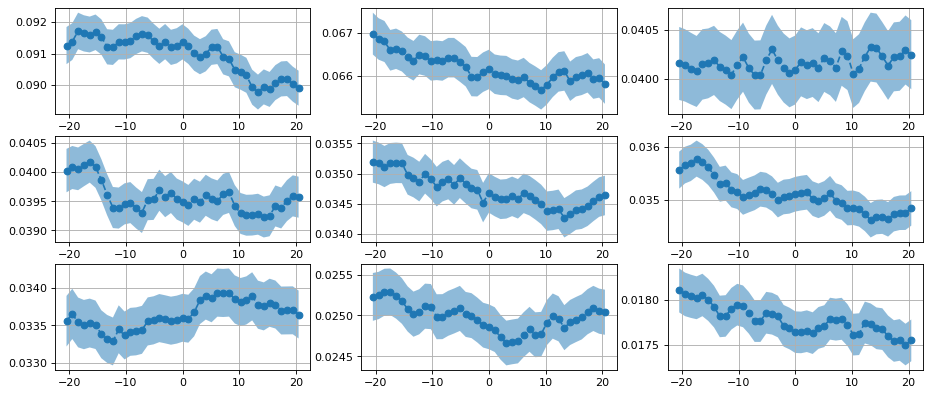

In [8]:
# plotting the rate per detector in each energy bin for the diffuse models
nr = 3
nc = 3
nplt = 1
fig = plt.figure(dpi=80, figsize=(14,6))
for j in range(9):
    ax = fig.add_subplot(nr,nc,nplt)
    nplt+=1
    try:
        rate_name = 'bkg_rate_' + str(j)
        rate = bkg_df[rate_name]
    except:
        rate_name = 'Background_bkg_rate_' + str(j)
        rate = bkg_df[rate_name]
    err0 = rate - bkg_df['err_'+rate_name]
    err1 = rate + bkg_df['err_'+rate_name]
    plt.fill_between(bkg_df['dt'], err0, err1, alpha=.5)
    plt.plot(bkg_df['dt'], rate, 'o--')
    plt.grid(True)


time with min counts, max counts
32.768000000000065 3.552713678800501e-14
counts at min time, max time
6760.0 8209.0
bkg mean, bkg std
7023.0 81.7038385963555


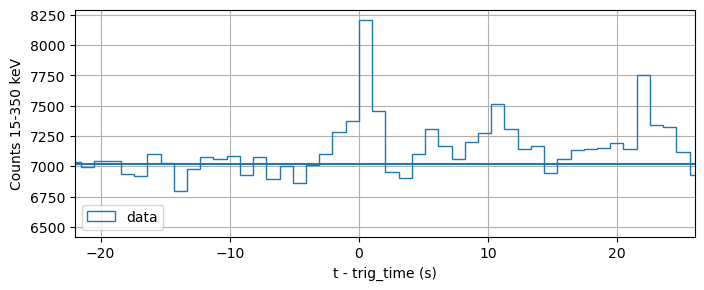

In [9]:
# plotting time hist of event data
tbins = np.arange(-40*1.024, 40*1.024, 0.064*4*4*1) # tbins with multiples of 64ms (64ms * 4 * 4 = 1.024s)
dt = tbins[1] - tbins[0]
tax = (tbins[1:] + tbins[:-1])/2.
ntbins = len(tax)
# choosing which tbins to estimate a flat bkg from for the plot
# bkg_bl = (np.abs(tax)>8.0)
bkg_bl = ((tax)<-10.0)&(tax>-40.0)

nc = 1
nr = 1
nplt = 1

fig = plt.figure(dpi=100, figsize=(8,3*nr))
ax = fig.add_subplot(nr,nc,nplt)
nplt += 1

h=plt.hist(ev_data0['TIME'] - trigger_time, bins=tbins,\
           histtype='step', label='data')[0]

bkg_mean = np.mean(h[bkg_bl])
bkg_std = np.std(h[bkg_bl])

print("time with min counts, max counts")
print (tbins[np.argmin(h)], tbins[np.argmax(h)])
print("counts at min time, max time")
print(np.min(h), np.max(h))
print("bkg mean, bkg std")
print(bkg_mean, bkg_std)

plt.axhline(bkg_mean)
plt.grid(True)
plt.xlim(-22, 26)
# plt.xlim(-4, 4.)
plt.ylim(np.around(.95*np.min(h[(h>0)]), decimals=-1),\
         np.round(1.01*np.max(h), decimals=-1))
plt.xlabel('t - trig_time (s)')
plt.ylabel('Counts 15-350 keV')
plt.legend(loc='lower left')

15.0 - 24.0 keV
time with min counts, max counts
-5.119999999999969 21.504000000000055
counts at min time, max time
1686.0 1884.0
bkg mean, bkg std
1774.7586206896551 28.503666034526997
24.0 - 35.0 keV
time with min counts, max counts
-14.335999999999977 26.62400000000006
counts at min time, max time
1009.0 1197.0
bkg mean, bkg std
1086.2413793103449 26.90167944047718
35.0 - 48.0 keV
time with min counts, max counts
-5.119999999999969 3.552713678800501e-14
counts at min time, max time
578.0 746.0
bkg mean, bkg std
627.7586206896551 24.485963850412542
48.0 - 64.0 keV
time with min counts, max counts
-40.96 3.552713678800501e-14
counts at min time, max time
564.0 774.0
bkg mean, bkg std
614.8620689655172 25.893314458570494
64.0 - 84.0 keV
time with min counts, max counts
32.768000000000065 3.552713678800501e-14
counts at min time, max time
482.0 675.0
bkg mean, bkg std
534.5172413793103 22.40938948783742
84.0 - 120.0 keV
time with min counts, max counts
-14.335999999999977 3.552713678800

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/tparsota/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldHungarian-Regular.ttf', name='Noto Sans Old Hungarian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Keyboard.ttf', name='.Keyboard', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansKhojki-Regular.ttf', name='Noto Sans Khojki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansPsalterPahlavi-Regular.ttf', name='Noto Sans Psalter Pahlavi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findf

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ明朝 ProN.ttc', name='Hiragino Mincho ProN', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansGothic-Regular.ttf', name='Noto Sans Gothic', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansHanunoo-Regular.ttf', name='Noto Sans Hanunoo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Hoefler Text.ttc', name='Hoefler Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Tamil Sangam MN.ttc', name='Tamil Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Black.ttf', name='Arial Black', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/DIN Condensed Bold.ttf', name='DIN Condensed', style='normal', variant='normal', weight=700, stretch='condensed', size='scalable')) = 10.535
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/KohinoorGujarati.ttc', name='Kohinoor Gujarati', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Libr

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Apple Braille.ttf', name='Apple Braille', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXVarBol.otf', name='STIXVariants', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Arial Italic.ttf', name='Arial', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 7.413636363636363
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Wingdings.ttf', name='Wingdings', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/SFCompactRounded

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOlChiki-Regular.ttf', name='Noto Sans Ol Chiki', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72 OS.ttc', name='Bodoni 72 Oldstyle', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCham-Regular.ttf', name='Noto Sans Cham', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXGeneralBolIta.otf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(Font

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W8.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=800, stretch='normal', size='scalable')) = 10.43
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOldPersian-Regular.ttf', name='Noto Sans Old Persian', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ArabicUIText.ttc', name='.Arabic UI Text', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Diwan Kufi.ttc', name='Diwan Kufi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supple

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansOsage-Regular.ttf', name='Noto Sans Osage', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc', name='Hiragino Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/ITFDevanagari.ttc', name='ITF Devanagari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Menlo.ttc', name='Menlo', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Gurmukhi.ttf',

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansBuhid-Regular.ttf', name='Noto Sans Buhid', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/STIXSizOneSymReg.otf', name='STIXSizeOneSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansNewTaiLue-Regular.ttf', name='Noto Sans New Tai Lue', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Verdana.ttf', name='Verdana', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 3.6863636363636365
DEBUG:matplotlib.font_manager:findfont: score

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')) = 10.525
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansMultani-Regular.ttf', name='Noto Sans Multani', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Marion.ttc', name='Marion', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Telugu Sangam MN.ttc', name='Telugu Sangam MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts

DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Bodoni 72.ttc', name='Bodoni 72', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/STHeiti Medium.ttc', name='Heiti TC', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Chalkduster.ttf', name='Chalkduster', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansTifinagh-Regular.ttf', name='Noto Sans Tifinagh', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/System/Library/Fonts/Suppleme

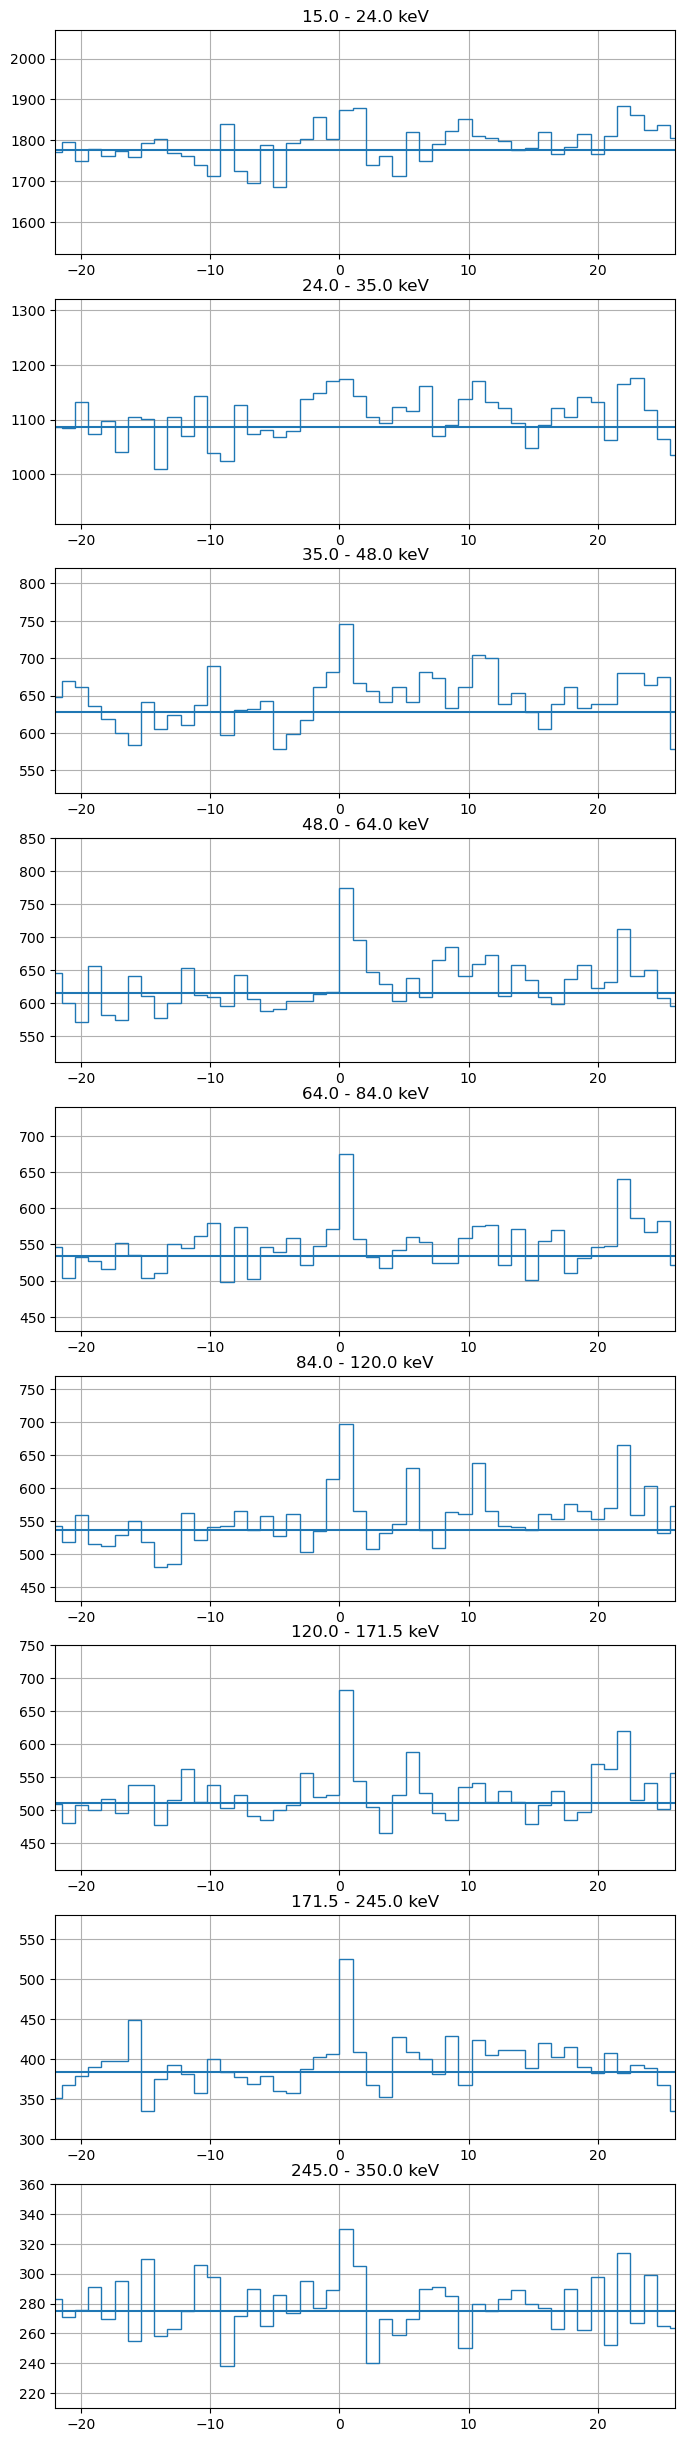

In [10]:
# plotting time hist with same bins as last cell but for each Ebin
nc = 1
nr = nebins
nplt = 1
fig = plt.figure(dpi=100, figsize=(8,3.5*nr))

for ei in range(nebins):
    ax = fig.add_subplot(nr,nc,nplt)
    nplt += 1
    ebl = (ev_data0['ENERGY']>=ebins0[ei])&\
            (ev_data0['ENERGY']<ebins1[ei])
    h=plt.hist(ev_data0[ebl]['TIME'] - trigger_time, bins=tbins,\
               histtype='step')[0]
    bkg_mean = np.mean(h[bkg_bl])
    bkg_std = np.std(h[bkg_bl])
    ttl = '%.1f - %.1f keV' %(ebins0[ei],ebins1[ei])
    print(ttl)
    print("time with min counts, max counts")
    print (tbins[np.argmin(h)], tbins[np.argmax(h)])
    print("counts at min time, max time")
    print(np.min(h), np.max(h))
    print("bkg mean, bkg std")
    print(bkg_mean, bkg_std)
    print
    plt.axhline(bkg_mean)
    plt.title(ttl)
    plt.grid(True)
#     plt.xlim(-2, 2)
    plt.xlim(-22, 26)
    plt.ylim(np.around(.9*np.min(h[(h>0)]), decimals=-1),\
             np.round(1.1*np.max(h), decimals=-1))

QUATERNION:  [-0.03597053  0.2345147  -0.64420835  0.72712074]
Pointing RA, Dec
273.5996900829163 -17.13930771538036


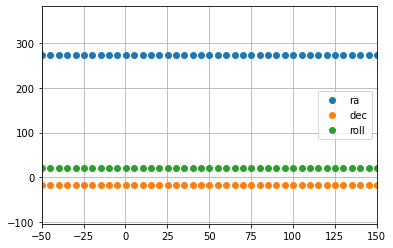

In [11]:
# getting attitude information at trigger time
att_ind = np.argmin(np.abs(attfile['TIME'] - trigger_time))
att_quat = attfile['QPARAM'][att_ind]
print("QUATERNION: ", att_quat)
pnt_ra, pnt_dec = attfile['POINTING'][att_ind,:2]
print("Pointing RA, Dec")
print(pnt_ra, pnt_dec)
plt.plot(attfile['TIME']-trigger_time, attfile['POINTING'], 'o')
plt.grid(True)
plt.xlim(-50,150)
plt.legend(['ra','dec','roll'])

In [12]:
# if you have some ra, dec of interest (like a gbm localization or something)
# here's how to do conversions into detector coordinates (theta, phi) and (imx, imy)
ra_interest, dec_interest = 233.117, -26.213
print("RA of interest, Dec of interest")
print(ra_interest, dec_interest)
theta_interest, phi_interest = convert_radec2thetaphi(ra_interest, dec_interest, att_quat)
print("theta, phi")
print (theta_interest, phi_interest)
# imx, imy only valid at theta < 90 deg
imx_interest, imy_interest = convert_radec2imxy(ra_interest, dec_interest, att_quat)
print("imx, imy")
print (imx_interest, imy_interest)

RA of interest, Dec of interest
233.117 -26.213
theta, phi
38.54132137017975 137.65241966813443
imx, imy
-0.5887551341212709 -0.5366203642198198


In [13]:
#%%time
# getting split rate analysis results

# get the file names
res_rate_fnames = get_rate_res_fnames(work_dir)
print("%d split rate result files"%(len(res_rate_fnames)))
# read files and merge into one Pandas Dataframe
res_rate_tab = get_merged_csv_df(res_rate_fnames, work_dir, ignore_index=True)
print("Merged split rate results table has %d rows"%(len(res_rate_tab)))
res_rate_tab['dt'] = res_rate_tab['time'] - trigger_time

24 split rate result files
Merged split rate results table has 53244 rows


In [14]:
res_rate_tab.sort_values('TS', ascending=False).head(64)

,4U 1700-377_rt_sum,A,Epeak,GRO J1655-40_rt_sum,GX 339-4_rt_sum,Sco X-1_rt_sum,TS,bkg_nllh,dur,gamma,imx,imy,ndets,nllh,solid_angle,time,timeID,hp_ind,phi,theta,dt
32553,3308.140625,0.005131,1000.000000,3096.148438,1976.254395,3396.428711,18.524986,261.024004,2.048,0.236981,0.08,-0.56,7147,89.436460,7206.133604,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
51729,3463.363281,0.005100,1000.000000,3397.006836,1976.254395,3573.353271,18.497463,264.219452,2.048,0.240639,-0.16,-0.56,7314,93.141376,7397.469045,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
17797,3897.023438,0.004559,1000.000000,3526.900879,1976.254395,4468.304688,18.450624,253.554914,2.048,0.187357,0.32,-0.40,9925,83.342152,10084.993057,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
25481,3542.836670,0.004821,1000.000000,3238.922852,1971.113525,4008.572021,18.420209,257.861285,2.048,0.221658,0.44,-0.40,8567,88.209233,8726.558695,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
35545,2914.345215,0.005365,1000.000000,2866.721680,1936.077148,2952.979980,18.413330,262.882505,2.048,0.264898,-0.10,-0.64,6090,93.357147,6129.661822,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
33233,3276.141602,0.004996,1000.000000,3046.996094,1964.611084,3501.029297,18.410200,255.301063,2.048,0.250540,0.38,-0.48,7545,85.833324,7671.704471,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
13853,3683.522461,0.004740,1000.000000,3367.135742,1976.254272,3998.754883,18.405803,256.258841,2.048,0.169867,0.26,-0.48,8639,86.872050,8773.869983,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
33981,4073.167236,0.004355,1000.000000,3558.800049,1976.254395,4918.258301,18.351019,251.132652,2.048,0.134831,0.38,-0.32,10908,82.752700,11082.322131,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
37109,2534.849609,0.005568,1000.000000,2437.718750,1814.178589,2535.038818,18.343302,260.442375,2.048,0.300736,0.14,-0.64,5263,92.204018,5257.262112,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512
26637,2739.820312,0.005432,1000.000000,2669.706787,1966.270020,2753.237061,18.331746,262.678926,2.048,0.271188,0.02,-0.64,5709,94.652475,5735.294086,6.460184e+08,-5122048,NaN,NaN,NaN,-0.512


In [15]:
#%%time
# getting out of FoV analysis results

res_out_fnames = get_out_res_fnames(work_dir)
print("%d out of FoV result files"%(len(res_out_fnames)))

res_out_tab = get_merged_csv_df_wpos(res_out_fnames, attfile, direc=work_dir, ignore_index=True)
print("Merged out of FoV results table has %d rows"%(len(res_out_tab)))
res_out_tab['dt'] = res_out_tab['time'] - trigger_time

2509 out of FoV result files
Merged out of FoV results table has 341224 rows


In [16]:
#%%time
# getting in FoV analysis results

res_peak_fnames = get_peak_res_fnames(work_dir)
print("%d in FoV peaks result files"%(len(res_peak_fnames)))
# read files and merge in single dataframe, also convert detector coords into RA, Dec
res_peak_tab = get_merged_csv_df_wpos(res_peak_fnames, attfile, direc=work_dir, ignore_index=True)
print("Merged in FoV peaks results table has %d rows"%(len(res_peak_tab)))
res_peak_tab['dt'] = res_peak_tab['time'] - trigger_time

1052 in FoV peaks result files
Merged in FoV peaks results table has 1282878 rows


In [17]:
# getting the max TS for each square/time seed combo
idx = res_peak_tab.groupby(['squareID','timeID'])['TS'].transform(max) == res_peak_tab['TS']
res_peak_maxSq_tab = res_peak_tab[idx]
print(len(res_peak_maxSq_tab))

2664


In [18]:
# initing flux model to calculate flux/fluences
flux_params = {'A':1.0, 'gamma':0.5, 'Epeak':1e2}
flux_mod = Cutoff_Plaw_Flux(E0=100.0)

In [19]:
#%%time
# calculating fluence for each row based on the best fit spectral parameters 
fluncs = np.zeros(len(res_peak_maxSq_tab))
flux_pars = {'A':1.0, 'Epeak':1e2, 'gamma':0.5}
i = 0
for ind, row in res_peak_maxSq_tab.iterrows():
    flux_pars['A'] = row['A']
    flux_pars['gamma'] = row['gamma']
    flux_pars['Epeak'] = row['Epeak']
    fluncs[i] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur'] # fluence from 10keV to 1MeV
    i+=1
#     res_peak_maxSq_tab.loc[ind]['fluence'] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur']
res_peak_maxSq_tab['fluence'] = fluncs

/var/folders/t4/r1b0srk10n335yds5g1g053c8nkvkq/T/ipykernel_23059/2023353641.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_peak_maxSq_tab['fluence'] = fluncs


In [20]:
# max TS peak result
print (np.max(res_peak_maxSq_tab['TS']))
idx = res_peak_maxSq_tab['TS'].idxmax()
row = res_peak_maxSq_tab.loc[idx]
max_TS_timeID = row['timeID']
row

18.889988375954648


Unnamed: 0    1.430000e+02
A             5.439460e-03
Epeak         9.189738e+02
TS            1.888999e+01
bkg_nllh      4.603944e+04
dur           2.048000e+00
gamma         2.000000e-01
imx          -5.890000e-01
imy          -5.350000e-01
nllh          4.586102e+04
phi           1.377505e+02
theta         3.850943e+01
time          6.460184e+08
timeID       -5.122048e+06
squareID      1.761000e+03
ra            2.331463e+02
dec          -2.614926e+01
dt           -5.119998e-01
fluence       2.006761e-06
Name: 847079, dtype: float64

In [21]:
res_peak_maxSq_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,imx,imy,nllh,phi,theta,time,timeID,squareID,ra,dec,dt,fluence
847079,143,0.005439,918.973797,18.889988,46039.440350,2.048,2.000000e-01,-0.589,-0.535,45861.024519,137.750529,38.509432,6.460184e+08,-5122048,1761,233.146251,-26.149265,-0.512,0.000002
985696,88,0.003991,918.973797,18.166359,46039.440348,2.048,-1.000000e-01,0.285,-0.372,45874.432043,52.543226,25.108943,6.460184e+08,-5122048,2865,282.469719,-41.065866,-0.512,0.000002
115667,161,0.004440,918.973797,18.099210,46039.440348,2.048,-2.775558e-17,0.265,-0.483,45875.649640,61.248438,28.851294,6.460184e+08,-5122048,2812,278.561099,-45.698056,-0.512,0.000002
100529,89,0.004446,918.973797,18.095792,46039.440349,2.048,-2.775558e-17,0.265,-0.483,45875.711503,61.248438,28.851294,6.460184e+08,-5122048,2813,278.561099,-45.698056,-0.512,0.000002
232424,116,0.004758,918.973797,18.092233,46039.440350,2.048,-2.775558e-17,-0.603,-0.491,45875.775909,140.845382,37.869285,6.460184e+08,-5122048,1712,233.702487,-24.195588,-0.512,0.000002
1253528,134,0.005309,918.973797,18.080242,46039.440350,2.048,2.000000e-01,-0.667,-0.559,45875.992777,140.034268,41.032075,6.460184e+08,-5122048,1661,230.254666,-24.851080,-0.512,0.000002
731240,296,0.005313,918.973797,18.078437,46039.440351,2.048,2.000000e-01,-0.667,-0.559,45876.025403,140.034268,41.032075,6.460184e+08,-5122048,1660,230.254666,-24.851080,-0.512,0.000002
608605,133,0.004331,918.973797,18.015078,46039.440349,2.048,-1.000000e-01,0.075,-0.493,45877.168832,81.349928,26.504159,6.460184e+08,-5122048,2562,265.791234,-42.798293,-0.512,0.000002
776444,140,0.005651,729.966834,17.972488,46039.440350,2.048,-2.775558e-17,-0.633,-0.537,45877.935185,139.690684,39.695902,6.460184e+08,-5122048,1711,231.737724,-25.013145,-0.512,0.000002
25900,142,0.004057,918.973797,17.972456,46039.440348,2.048,-1.000000e-01,0.231,-0.401,45877.935760,60.055483,24.833586,6.460184e+08,-5122048,2765,278.302542,-41.648896,-0.512,0.000002


In [22]:
# max TS out result
print (np.max(res_out_tab['TS']))
idx = res_out_tab['TS'].idxmax()
row = res_out_tab.loc[idx]
max_TSout_timeID = row['timeID']
row

17.930498271444115


Unnamed: 0    2.600000e+01
A             2.254872e-02
Epeak         6.309573e+02
TS            1.793050e+01
bkg_nllh      4.603944e+04
dur           2.048000e+00
gamma         1.600000e+00
nllh          4.587869e+04
phi           1.553214e+02
theta         7.526322e+01
time          6.460184e+08
timeID       -5.122048e+06
hp_ind        1.611000e+03
ra            1.968750e+02
dec          -7.180756e+00
dt           -5.119998e-01
Name: 221978, dtype: float64

In [23]:
res_out_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,nllh,phi,theta,time,timeID,hp_ind,ra,dec,dt
221978,26,0.022549,630.957344,17.930498,46039.440354,2.048,1.6,45878.688970,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221985,33,0.022179,1584.893192,17.929094,46039.440354,2.048,1.8,45878.714140,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221981,29,0.020974,1000.000000,17.929017,46039.440354,2.048,1.6,45878.715529,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221975,23,0.020974,1000.000000,17.929017,46039.440354,2.048,1.6,45878.715529,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221982,30,0.022679,1000.000000,17.922284,46039.440354,2.048,1.8,45878.836218,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221984,32,0.019930,1584.893192,17.921898,46039.440354,2.048,1.6,45878.843140,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221970,18,0.024943,398.107171,17.915766,46039.440354,2.048,1.6,45878.953011,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221979,27,0.023441,630.957344,17.909630,46039.440354,2.048,1.8,45879.062929,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
221977,25,0.021301,630.957344,17.895092,46039.440354,2.048,1.4,45879.323197,155.321410,75.263221,6.460184e+08,-5122048,1611,196.8750,-7.180756,-0.512
80134,30,0.016178,398.107171,17.894867,46039.440354,2.048,2.4,45879.327226,112.677901,64.787443,6.460184e+08,-5122048,2701,202.5000,-48.141208,-0.512


In [24]:
# get best out of FoV result for each healpix pixel for a certrain time bin
bl = np.isclose(res_out_tab['timeID'],max_TSout_timeID)
idx = res_out_tab[bl].groupby(['hp_ind'])['TS'].transform(max) == res_out_tab[bl]['TS']
res_hpmax_tab = res_out_tab[bl][idx]

In [25]:
#%%time
# get fluence for each row of res_hpmax_tab
fluncs = np.zeros(len(res_hpmax_tab))
flux_pars = {'A':1.0, 'Epeak':1e2, 'gamma':0.5}
# for i in range(len(res_peak_maxSq_tab)):
i = 0
for ind, row in res_hpmax_tab.iterrows():
    flux_pars['A'] = row['A']
    flux_pars['gamma'] = row['gamma']
    flux_pars['Epeak'] = row['Epeak']
    fluncs[i] = get_eflux_from_model(flux_mod, flux_pars, 1e1, 1e3)*row['dur']
    i+=1
res_hpmax_tab['fluence'] = fluncs

In [26]:
res_hpmax_tab.sort_values('TS', ascending=False).head(64)

,Unnamed: 0,A,Epeak,TS,bkg_nllh,dur,gamma,nllh,phi,theta,time,timeID,hp_ind,ra,dec,dt,fluence
221978,26,0.022549,630.957344,17.930498,46039.440354,2.048,1.6,45878.688970,155.321410,75.263221,6.460184e+08,-5122048,1611,196.875000,-7.180756,-0.512,0.000003
80134,30,0.016178,398.107171,17.894867,46039.440354,2.048,2.4,45879.327226,112.677901,64.787443,6.460184e+08,-5122048,2701,202.500000,-48.141208,-0.512,0.000003
55786,26,0.015754,251.188643,17.866926,46039.440354,2.048,2.2,45879.826837,66.506182,64.258877,6.460184e+08,-5122048,2824,285.000000,-81.219822,-0.512,0.000003
154936,32,0.024452,1584.893192,17.840089,46039.440354,2.048,1.6,45880.305961,156.884201,78.620145,6.460184e+08,-5122048,1633,194.062500,-4.780192,-0.512,0.000004
107065,33,0.018177,630.957344,17.821293,46039.440354,2.048,1.8,45880.641119,37.350698,71.161062,6.460184e+08,-5122048,2881,355.500000,-60.434439,-0.512,0.000003
283719,23,0.022506,1000.000000,17.818541,46039.440354,2.048,1.6,45880.690145,160.059037,76.623800,6.460184e+08,-5122048,1636,196.875000,-2.388015,-0.512,0.000003
283725,29,0.022506,1000.000000,17.818541,46039.440354,2.048,1.6,45880.690145,160.059037,76.623800,6.460184e+08,-5122048,1636,196.875000,-2.388015,-0.512,0.000003
148545,33,0.018373,630.957344,17.808011,46039.440354,2.048,1.8,45880.877722,40.533213,70.874880,6.460184e+08,-5122048,2880,355.000000,-63.448284,-0.512,0.000003
202400,32,0.022516,1584.893192,17.806689,46039.440354,2.048,1.6,45880.901276,152.154065,77.287722,6.460184e+08,-5122048,1610,194.062500,-9.594068,-0.512,0.000004
89514,26,0.015306,251.188643,17.802646,46039.440354,2.048,2.2,45880.973252,76.323252,63.713755,6.460184e+08,-5122048,2566,236.250000,-78.284148,-0.512,0.000003


In [27]:
def get_dlogl_peak_out(res_peak_tab, res_out_tab):
    '''
    returns DeltaLLH_peak and DeltaLLH_out for the time bin with the max TS
    '''
    
    idx = res_peak_tab['TS'].idxmax()
    row = res_peak_tab.loc[idx]
    
    timeID = row['timeID']
    imdists = im_dist(row['imx'], row['imy'], res_peak_tab['imx'], res_peak_tab['imy'])
    bld = (imdists>0.012)&(res_peak_tab['timeID']==timeID)
    
    dlogl_peak = np.nanmin(res_peak_tab[bld]['nllh']) - row['nllh']
    
    blo = (res_out_tab['timeID']==timeID)
    
    dlogl_out = np.nanmin(res_out_tab[blo]['nllh']) - row['nllh']
    
    return dlogl_peak, dlogl_out

def get_dlogls_inout(res_tab, res_out_tab):
    '''
    returns DeltaLLH_peak, DeltaLLH_out, timeID for each time bin
    '''
    
    dlogls = []
    dlogls_in_out = []
    timeIDs = []
    for timeID, df in res_tab.groupby('timeID'):
        idx = df['TS'].idxmax()
        row = df.loc[idx]
        imdists = im_dist(row['imx'], row['imy'], df['imx'], df['imy'])
        bld = (imdists>0.012)
        try:
            dlogls.append(np.nanmin(df[bld]['nllh']) - row['nllh'])
        except Exception as E:
            print(E)
            dlogls.append(np.nan)
        blo = np.isclose(res_out_tab['timeID'],timeID,rtol=1e-9,atol=1e-3)
        dlogls_in_out.append(np.nanmin(res_out_tab[blo]['nllh']) - row['nllh'])
        timeIDs.append(timeID)
    return dlogls, dlogls_in_out, timeIDs

In [28]:
dlogl_peak, dlogl_out = get_dlogl_peak_out(res_peak_tab, res_out_tab)
print("\Delta LLH_peak = %.3f"%(dlogl_peak))
print("\Delta LLH_out = %.3f"%(dlogl_out))

\Delta LLH_peak = 13.408
\Delta LLH_out = 17.664


In [29]:
# %%time
dlogls_peak, dlogls_out, list_timeIDs = get_dlogls_inout(res_peak_tab, res_out_tab)
for i in range(len(list_timeIDs)):
    print( "timeID = %d"%(list_timeIDs[i]))
    print( "\Delta LLH_peak = %.3f"%(dlogls_peak[i]))
    print ("\Delta LLH_out = %.3f"%(dlogls_out[i]))
    print()

timeID = -5122048
\Delta LLH_peak = 13.408
\Delta LLH_out = 17.664

timeID = -2561024
\Delta LLH_peak = 0.842
\Delta LLH_out = 7.147

timeID = 1024
\Delta LLH_peak = 0.449
\Delta LLH_out = 2.511

timeID = 2561024
\Delta LLH_peak = 0.341
\Delta LLH_out = 4.529

